In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/README.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/LICENSE.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa18_test.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa4_valid.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa15_test.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa7_valid.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa14_test.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa7_train.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa16_valid.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa15_valid.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa8_test.txt
/kaggle/input/the-babi-tasks-for-nlp-qa-system/tasks_1-20_v1-2/en-valid/qa1_

In [194]:
import numpy as np

from nltk.tokenize import word_tokenize

import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

import tarfile
import re
from functools import reduce


In [37]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)

In [195]:
def tokenize(sent):
    '''
    argument: a sentence string
    returns a list of tokens(words)
    '''
    return word_tokenize(sent)
 
def parse_stories(lines):
    '''
    - Parse stories provided in the bAbI tasks format
    - A story starts from line 1 to line 15. Every 3rd line,
      there is a question &amp;amp;amp;amp;amp; answer.
    - Function extracts sub-stories within a story and
      creates tuples
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # this line is tab separated Q, A &amp;amp;amp;amp;amp; support fact ID
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sent = tokenize(line)
            story.append(sent)
    return data
 
def get_stories(f):
    '''
    argument: filename
    returns list of all stories in the argument data-set file
    '''
    # read the data file and parse 10k stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [196]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
print('Extracting stories for the challenge: single_supporting_fact_10k')
# Extracting train stories
train_stories = get_stories(tar.extractfile(challenge.format('train')))
# Extracting test stories
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k


In [197]:
vocab = set()
for story,question,answer in train_stories + test_stories:
    vocab |= set(story + question + [answer])
vocab = sorted(vocab)
vocab_size = len(vocab) +1
print(f"Lenght of Vocab  : {len(vocab)}")

Lenght of Vocab  : 21


In [198]:
word_to_idx = {w:idx for idx,w in enumerate(vocab)}
idx_to_word = {idx:w for idx,w in enumerate(vocab)}

story_maxlen = max(map(len,(x for x,_,_ in train_stories +test_stories)))
query_maxlen = max(map(len,(x for _,x,_ in train_stories +test_stories)))

In [199]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    # story vector initialization
    X = []
    # query vector initialization
    Xq = []
    # answer vector intialization
    Y = []
    for story, query, answer in data:
        # creating list of story word indices
        x = [word_idx[w] for w in story]
        # creating list of query word indices
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        # creating label 1 for the answer word index
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [200]:
# vectorize train story, query and answer sentences/word using vocab
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,word_to_idx,story_maxlen,query_maxlen)
# vectorize test story, query and answer sentences/word using vocab
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,word_to_idx,story_maxlen,query_maxlen)

In [201]:
# number of epochs to run
train_epochs = 100
# Training batch size
batch_size = 32
# Hidden embedding size
embed_size = 50
# number of nodes in LSTM layer
lstm_size = 64
# dropout rate
dropout_rate = 0.30

In [46]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
 
print('Input sequence:', input_sequence)
print('Question:', question)
 
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, embedding_dim)
 
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, query_maxlen)
 
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))
# output: (samples, query_maxlen, embedding_dim)
 
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)
 
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)
 
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)
 
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")
(None, 68, 4)
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activati

2022-02-16 11:17:10.908651: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [47]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 50)     1100        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 50)        1100        input_2[0][0]                    
______________________________________________________________________________________________

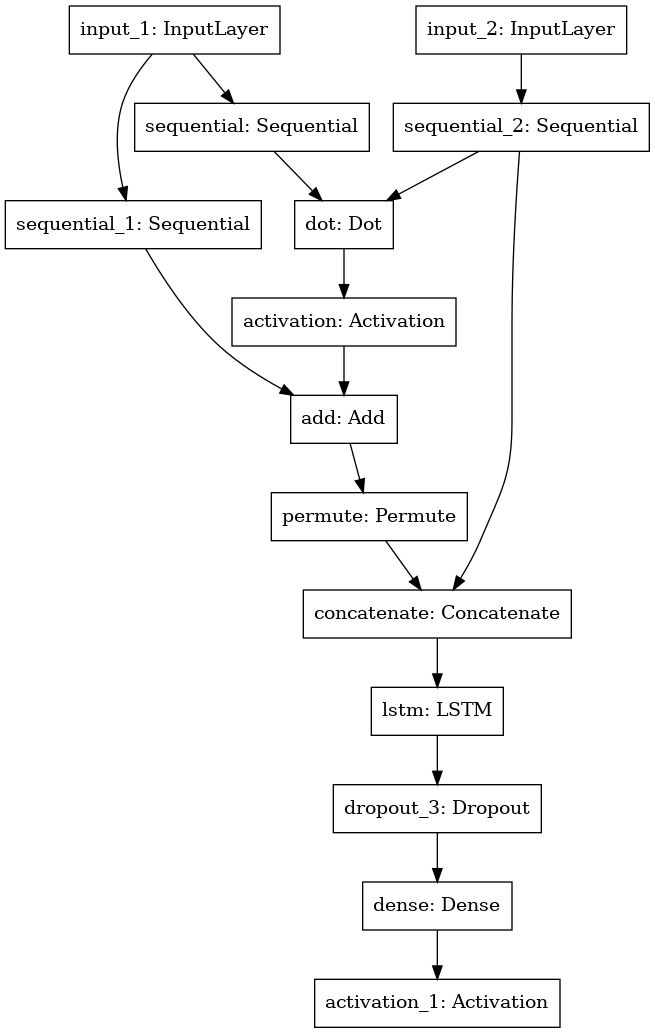

In [48]:
plot_model(model)

In [53]:
# start training the model
history = model.fit([inputs_train, queries_train], answers_train, 
                    batch_size=batch_size, 
                    epochs=train_epochs,
                    validation_data=([inputs_test, queries_test], answers_test))
 
# save model
model.save('model.h5')

2022-02-16 11:34:22.919341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
313/313 [==============================] - 9s 15ms/step - loss: 1.8850 - accuracy: 0.1722 - val_loss: 1.7991 - val_accuracy: 0.1570
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 1.7078 - accuracy: 0.2569 - val_loss: 1.6274 - val_accuracy: 0.3170
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 1.5767 - accuracy: 0.3626 - val_loss: 1.5054 - val_accuracy: 0.3980
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 1.4892 - accuracy: 0.4266 - val_loss: 1.4043 - val_accuracy: 0.4490
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 1.4128 - accuracy: 0.4576 - val_loss: 1.3343 - val_accuracy: 0.4880
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 1.3833 - accuracy: 0.4650 - val_loss: 1.3341 - val_accuracy: 0.4820
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 1.3644 - accuracy: 0.4728 - val_loss: 1.3004 - val_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [227]:
for i in range(0,10):
    current_inp = test_stories[i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_to_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_pred = idx_to_word[np.argmax(current_prediction)]
    ques = " ".join(current_inp[1])
    print(f"Question : {ques} \nAnswer : {current_pred}")
    print("--------------------------------\t")

Question : Where is John ? 
Answer : hallway
--------------------------------	
Question : Where is Mary ? 
Answer : bathroom
--------------------------------	
Question : Where is Sandra ? 
Answer : kitchen
--------------------------------	
Question : Where is Sandra ? 
Answer : hallway
--------------------------------	
Question : Where is Sandra ? 
Answer : kitchen
--------------------------------	
Question : Where is Sandra ? 
Answer : hallway
--------------------------------	
Question : Where is Sandra ? 
Answer : garden
--------------------------------	
Question : Where is Daniel ? 
Answer : hallway
--------------------------------	
Question : Where is Sandra ? 
Answer : office
--------------------------------	
Question : Where is Daniel ? 
Answer : office
--------------------------------	


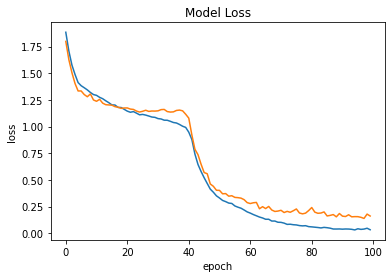

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel("loss")
plt.xlabel('epoch')
plt.show()

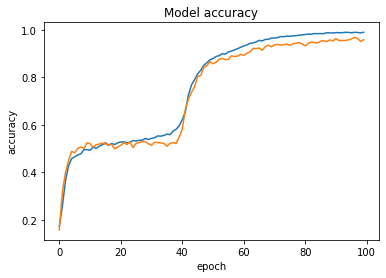

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.show()